In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils

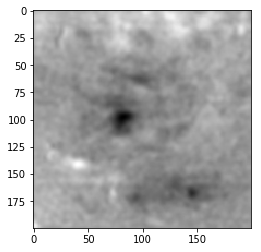

In [2]:
re_list = np.load('test_npy/7-12-17-processed_dF.npy')
IMG_SIZE = re_list.shape[1]

#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
re_list = re_list.astype('float32')

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

(200, 200, 1) float32


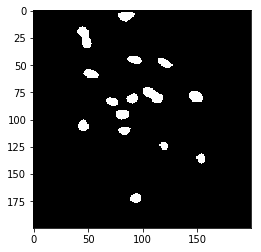

In [3]:
#retrieve and plot mean_ROI
mean_roi = np.load("/home/kevinteng/Desktop/mat/dg-13-7-12-17ROIs.mat_ROImask.npy")
mean_roi = cv2.resize(mean_roi, (200, 200))
#Dimension for network should include the color channel 
mean_roi = np.expand_dims(mean_roi, axis = -1)
#Cast data type to float32 for TensorFlow
mean_roi = mean_roi.astype('float32')

print(mean_roi.shape, mean_roi.dtype)
plt.imshow(np.squeeze(mean_roi), cmap = 'gray')

In [4]:
#calculate mean image
sums = np.zeros((200,200))
total_index = 0
for i in range(len(re_list)):
    sums+=np.squeeze(re_list[i])
    total_index+=1

mean_img = sums/total_index

#apply min max norm for mean image
mean_img = utils.min_max_norm(mean_img)

print('Max value:', np.max(mean_img))
print('Min value:', np.min(mean_img))

Max value: 1.0
Min value: 0.0


In [5]:
def MSE_image(img1, img2):
    img1, img2 = np.squeeze(img1), np.squeeze(img2)
    sq_error = (img1-img2)**2
    sums = np.sum(sq_error)
    
    return sums/(IMG_SIZE*IMG_SIZE)

print('MSE: ', MSE_image(mean_img, mean_roi))

MSE:  0.5853541413723683


In [6]:
def plot_2(ori_imgs, recon_imgs, figsize = (5, 5)):
    '''
    Plot comparison of one original and one reconstructed image
    '''
    print()
    fig, axes = plt.subplots(1, 2, figsize = figsize)
    fig.subplots_adjust(hspace=0.4, wspace = 0.4, right =0.7)
    
    axes[0].imshow(np.reshape(ori_imgs,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[0].set_xlabel('Mean image from the network')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(np.reshape(recon_imgs,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[1].set_xlabel('Mean ROI')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
def plot_loss(loss_list, recon_list = None):
    plt.xlabel('Number of every 100 Steps')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(linestyle='dotted')
    plt.plot(loss_list)

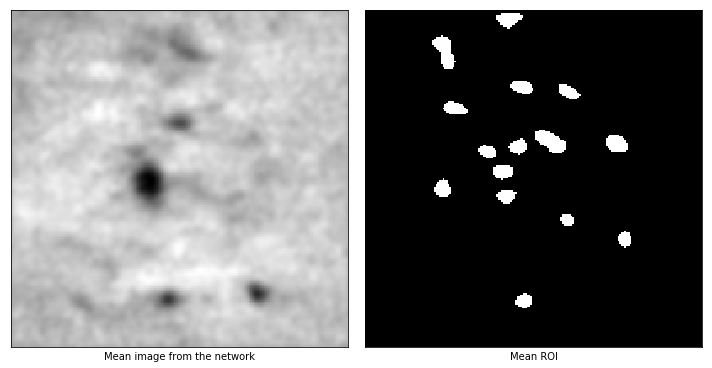

In [7]:
plot_2(mean_img, mean_roi, figsize = (10, 10))

In [8]:
BATCH_SIZE = 32
MAX_STEP = 2000
REPEAT = 1000
lr = 1e-3

ds_train = tf.data.Dataset.from_tensor_slices(re_list).shuffle(10000).repeat(REPEAT).batch(BATCH_SIZE)

In [9]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1

l1_coeff = 0.01
filters_layer = [32, 64]

def conv_block(x_in, filters, kernel_size, strides, padding, activation, kernel_regularizer = False,    
               batch_norm = False, max_pool = False):
    '''
    Build convolutional block with batch normalization
    '''
    if kernel_regularizer:
        print('L1 regularizer is activate!')
        x = Conv2D(filters, kernel_size, strides, padding, kernel_regularizer = l1(l1_coeff))(x_in)
    else:
        x = Conv2D(filters, kernel_size, strides, padding)(x_in)
        
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    if max_pool:
        assert strides < 2 or strides < (2,2), "Downsampling too fast for strides greater than 2"
        
        x = MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'same')(x)
        
    return x 

def coordconv_block(x_in, x_dim, y_dim, filters, kernel_size, strides, padding, activation,  
              kernel_regularizer = False, batch_norm = False, max_pool = False, with_r = False):
    '''
    Build coordconv block with batch normalization
    '''
    if kernel_regularizer:
        print('L1 regularizer is activate!')
        x = CoordConv(x_dim, y_dim, with_r, filters, kernel_size, 
                      strides, padding, kernel_regularizer = l1(l1_coeff))(x_in)
    else:
        x = CoordConv(x_dim, y_dim, with_r, filters, kernel_size, strides, padding)(x_in)
    
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    if max_pool:
        assert strides < 2 or strides < (2,2), "Downsampling too fast for strides greater than 2"
        
        x = MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'same')(x)
        
    return x 

def Coord_conv(input_layer):
    coordconv_01 = coordconv_block(input_layer, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[0], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True)
    coordconv_02 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True)
    coordconv_03 = coordconv_block(coordconv_02, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = 1, kernel_size = 3, strides = 1, padding='same', 
                                       activation='sigmoid')
    return coordconv_03

def Convnet(input_layer):
    conv_01 = conv_block(input_layer, filters = filters_layer[0], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True) 
    conv_02 = conv_block(conv_01, filters = filters_layer[1], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True) 
    conv_03 = conv_block(conv_02, filters = 1, kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'sigmoid') 
    return conv_03


In [10]:
# model = Sequential([    
#     CoordConv(x_dim = IMG_SIZE, y_dim = IMG_SIZE, with_r = False, filters = 32, 
#            kernel_size = 3, padding = 'same', activation = 'relu'),
#     CoordConv(x_dim = IMG_SIZE, y_dim = IMG_SIZE, with_r = False, filters = 64, 
#            kernel_size = 3, padding = 'same', activation = 'relu'),
#     CoordConv(x_dim = IMG_SIZE, y_dim = IMG_SIZE, with_r = False, filters = 1, 
#            kernel_size = 3, padding = 'same', activation = 'sigmoid')
# ])

# model = Sequential([    
#     Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
#     Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
#     Conv2D(filters = 1, kernel_size = 3, padding = 'same', activation = 'sigmoid')
# ])


# model.build((None, 200, 200, 1))

In [11]:
coordconv = True #toggle for coordconv and regular convnet
input_layer = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

if coordconv:
    print('The model is in Coordconv')
    model = Model(input_layer, Coord_conv(input_layer))
else:
    print('The model is in regular Conv-net')
    model = Model(input_layer, Convnet(input_layer))

The model is in Coordconv


In [12]:
def img_mean(imgs):
    sums = tf.zeros((200,200))
    total_index = 0
    for i in range(20):
        sums+=tf.squeeze(imgs[i])
        total_index+=1
    
    mean_img = sums/total_index
    return tf.expand_dims(mean_img, axis = -1)

In [13]:
#loss function
loss_fn = tf.losses.MeanSquaredError()
#optimizer 
opt = tf.optimizers.Adam(lr)

max_step_num = int((len(re_list)*REPEAT)/BATCH_SIZE)
print('Total number of steps: ',max_step_num)
print()

def img_mean(imgs):
    sums = tf.zeros((200,200))
    total_index = 0
    for i in range(imgs.shape[0]):
        sums+=tf.squeeze(imgs[i])
        total_index+=1
    
    mean_img = sums/total_index
    return tf.expand_dims(mean_img, axis = -1)

def min_max_norm(images):
    """
    Modified Min max normalization of images in Tensorflow
    Parameters:
        images: Input stacked image list
    Return:
        Image list after min max normalization
    """
    m = tf.math.reduce_max(images)
    mi = tf.math.reduce_min(images)
    images = (images - mi)/ (m - mi)
    return images

@tf.function
def train(imgs, mean_roi):
    with tf.GradientTape() as tape:
        conv_img = model(imgs) #(batch, img_size, img_size)
        mean_img = img_mean(conv_img)
        mean_img = min_max_norm(mean_img) #apply min max norm
        xent = loss_fn(mean_img, mean_roi)
    grads = tape.gradient(xent, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return xent, mean_img

ori_list = [] #original image list
de_list = [] #mean image fromt the network list
loss_list = [] #loss list

for step, (img_batch) in enumerate(ds_train):
    if step > MAX_STEP:
        print('End of MAX_STEP!')
        break
        
    xent, mean_img = train(img_batch, mean_roi)
    ori_list.append(img_batch)
    de_list.append(mean_img)
    
    if not step % 100:
        loss_list.append(xent)
        print("Step {}, Loss: {}".format(step, xent.numpy()))
        #plot_2(mean_img[0], mean_roi, figsize = (10,10))

Total number of steps:  18906

Step 0, Loss: 0.258237361907959
Step 100, Loss: 0.031117230653762817
Step 200, Loss: 0.030572619289159775
Step 300, Loss: 0.030396802350878716
Step 400, Loss: 0.028913628309965134
Step 500, Loss: 0.028914257884025574
Step 600, Loss: 0.02841528318822384
Step 700, Loss: 0.027991535142064095
Step 800, Loss: 0.027411067858338356
Step 900, Loss: 0.028483767062425613
Step 1000, Loss: 0.028048183768987656
Step 1100, Loss: 0.02676204778254032
Step 1200, Loss: 0.02693319134414196
Step 1300, Loss: 0.026973269879817963
Step 1400, Loss: 0.026766091585159302
Step 1500, Loss: 0.02707790583372116
Step 1600, Loss: 0.025149835273623466
Step 1700, Loss: 0.024008765816688538
Step 1800, Loss: 0.02419230341911316
Step 1900, Loss: 0.021398084238171577
Step 2000, Loss: 0.02314264327287674
End of MAX_STEP!


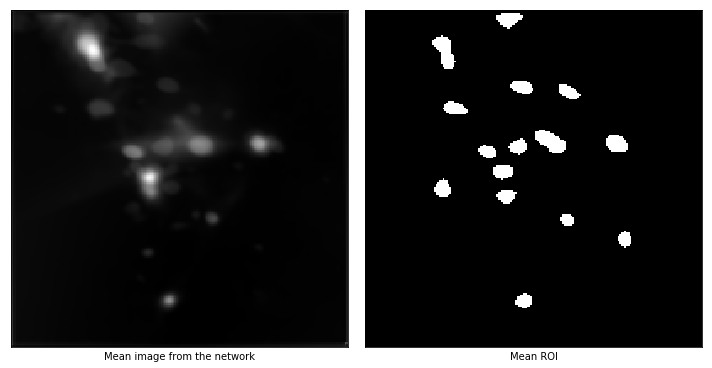

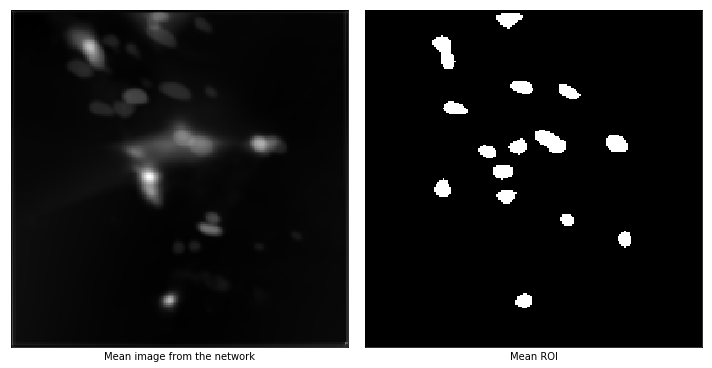

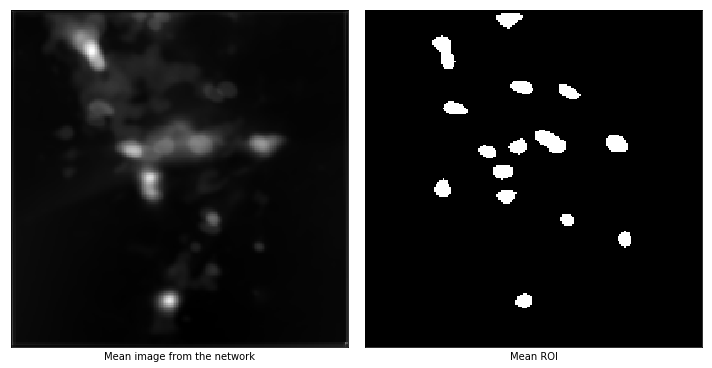

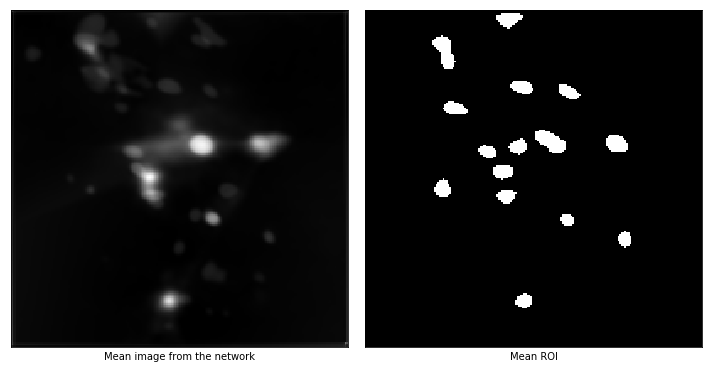

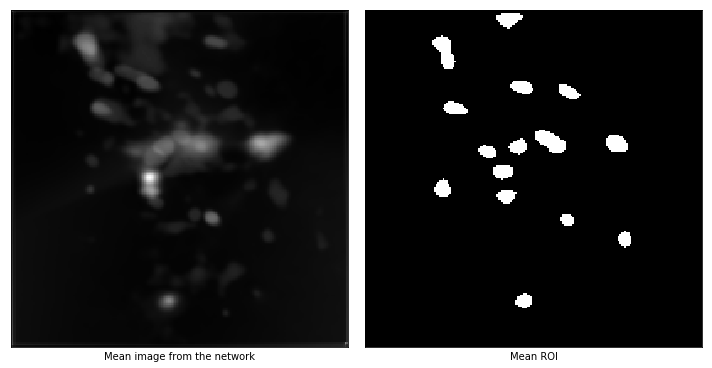

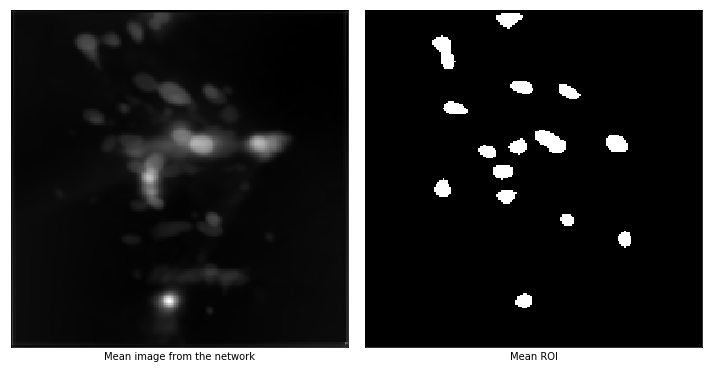

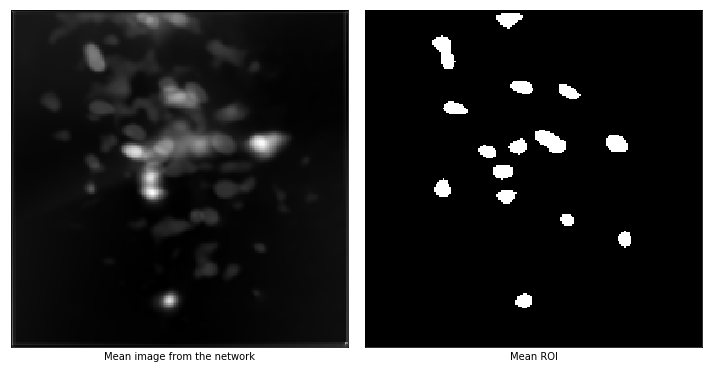

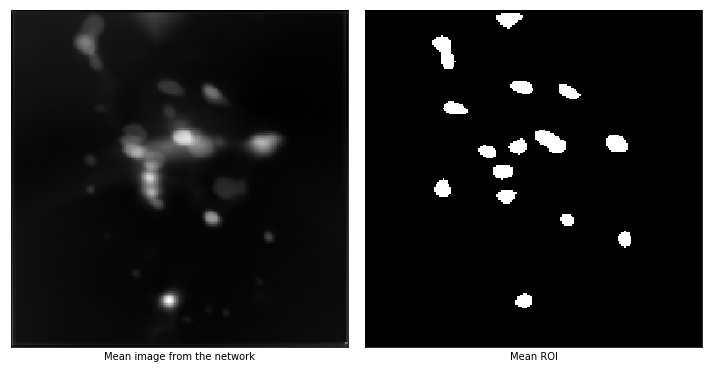

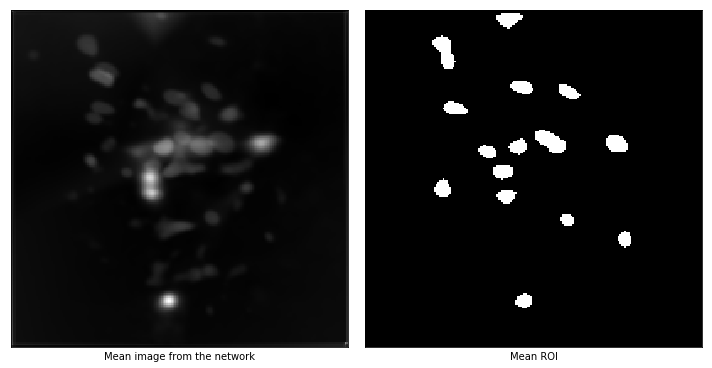

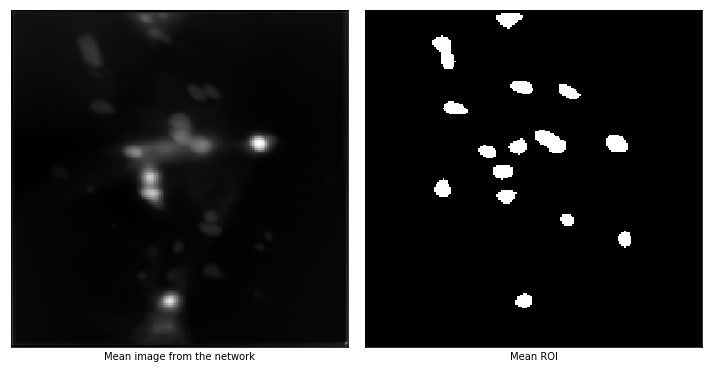

In [14]:
for i in range(10):
    plot_2(de_list[MAX_STEP - 10 + i], mean_roi, figsize = (10,10))

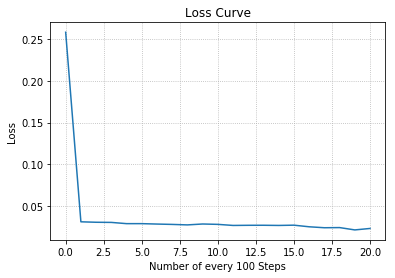

In [15]:
plot_loss(loss_list)

In [16]:
def layers_dict( model):
    '''
    :param model: deep learning model

    :return:
        Dictionary with 'key': layer names, value: layer information
    '''
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    return layer_dict

def feature_maps(model, layer_name, inps):
    '''
    This function visualize the intermediate activations of the filters within the layers
    :param model: deep learning model
    :param layer_name: desired layer name, if forgotten, please refer to layers_dict function
    :param inps: feed the network with input, such as images, etc. input dimension
                 should be 4.

    :return:
        feature maps of the layer specified by layer name,
        with dimension ( batch, row size, column size, channels)
    '''
    assert inps.ndim == 4, "Input tensor dimension not equal to 4!"
    #retrieve key value from layers_dict
    layer_dict = layers_dict(model)

    #layer output with respect to the layer name
    layer_output = layer_dict[layer_name].output
    viz_model = Model(inputs=model.inputs, outputs=layer_output)
    feature_maps = viz_model.predict(inps)

    print('Shape of feature maps:', feature_maps.shape)
    #shape (batch, row size, column size, channels)
    return feature_maps

def plot_feature_maps(inps, row_num, col_num, figsize):
    '''
    This function can only plot the feature maps of a model
    :param inps: feature maps
    :param row_num: number of rows for the plot
    :param col_num: number of columns for the plot

    :return:
        grid plot of size (row_num * col_num)
    '''
    assert inps.ndim == 4, "Input tensor dimension not equal to 4!"

    print("Number of feature maps in layer: ", inps.shape[-1])

    fig, axes = plt.subplots(row_num, col_num, figsize = figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i, ax in enumerate(axes.flat):
        img = inps[0, :, :, i]

        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.tight_layout()
    plt.show()

In [17]:
layer_dict = layers_dict(model)
key_list = []
for key, value in layer_dict.items():
    key_list.append(key)
    print(key)

input_1
coord_conv
batch_normalization_v2
activation
coord_conv_1
batch_normalization_v2_1
activation_1
coord_conv_2
activation_2


In [18]:
if coordconv:
    layer_name = 'coord_conv'
else:
    layer_name = 'conv2d'
    
layer_output = layer_dict[layer_name].output

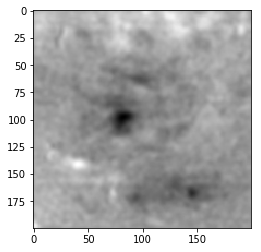

In [19]:
test_img = np.asarray(tf.expand_dims(re_list[0], 0))
plt.imshow(np.squeeze(test_img), cmap = 'gray')
plt.show()

Shape of feature maps: (1, 200, 200, 64)
Number of feature maps in layer:  64


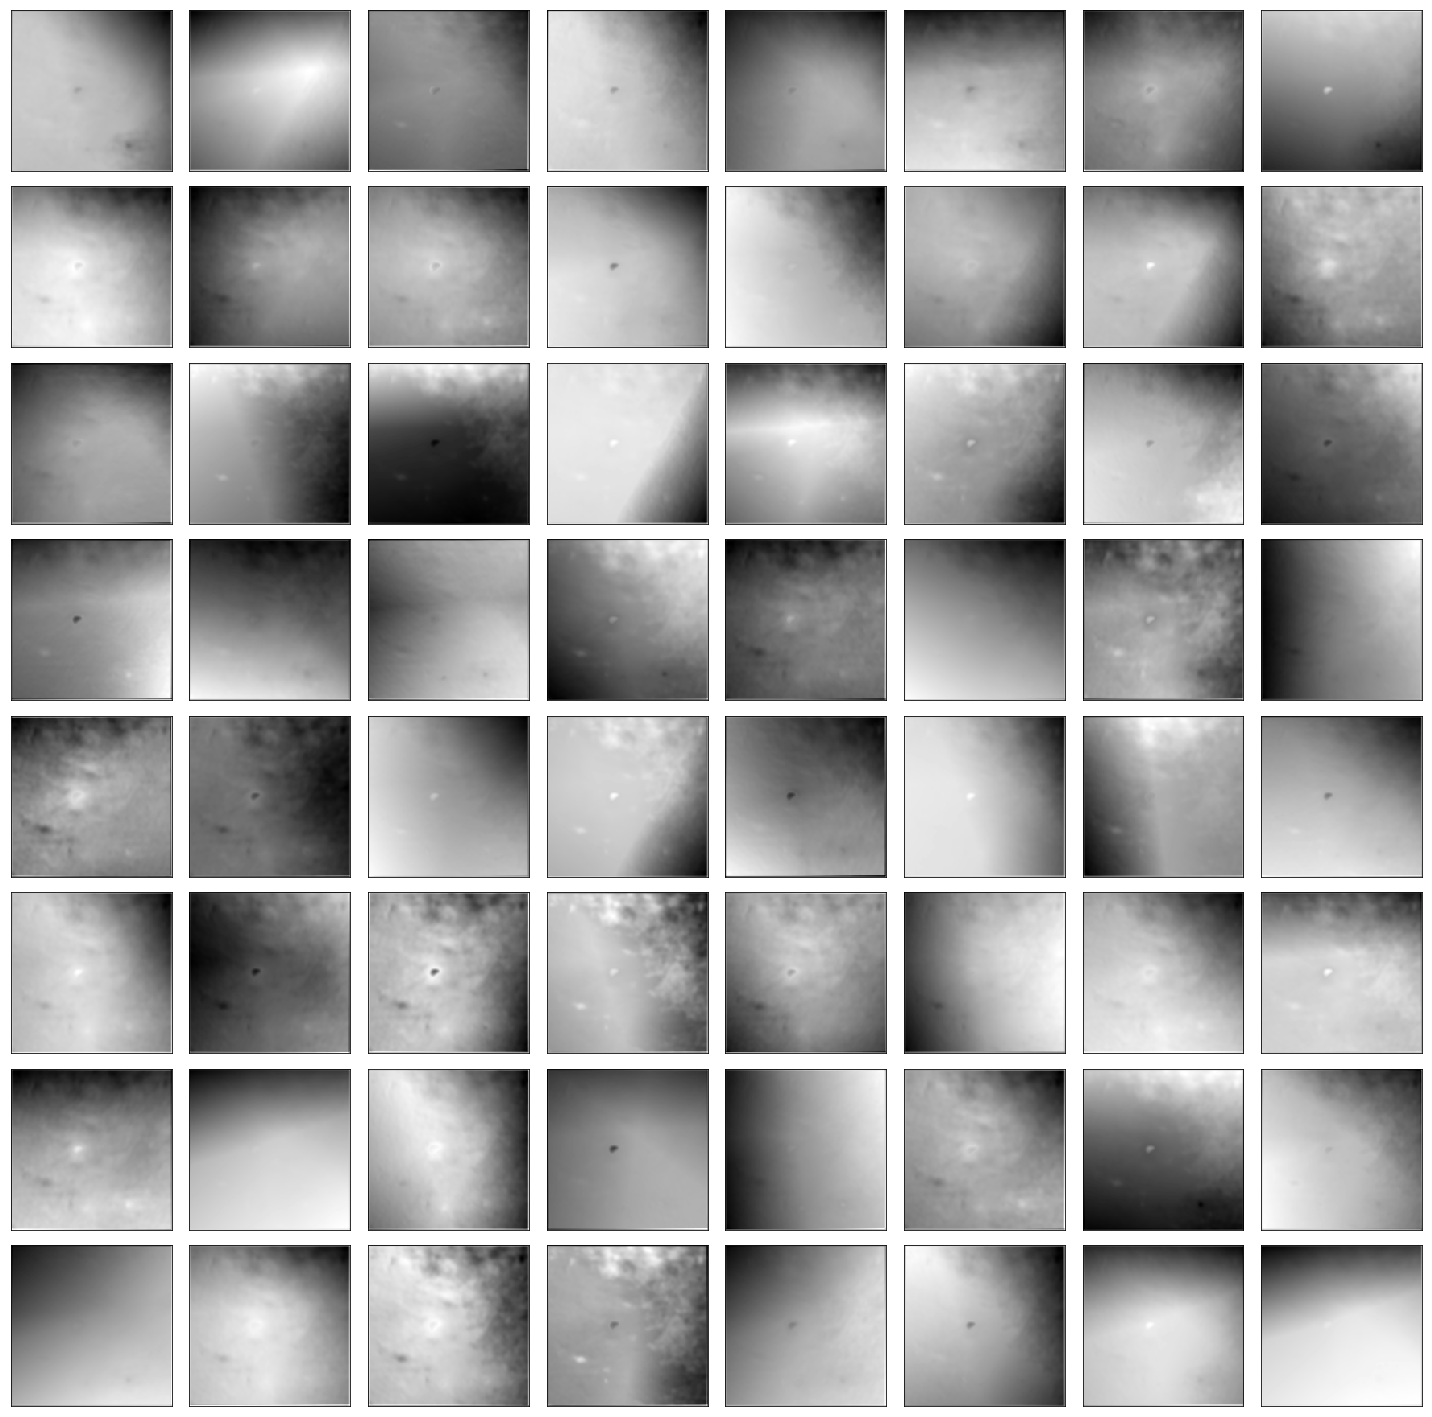

In [20]:
test_map = feature_maps(model, '{}_1'.format(layer_name), test_img)
plot_feature_maps(test_map, 8, 8, figsize = (20,20))

Shape of feature maps: (1, 200, 200, 32)
Number of feature maps in layer:  32


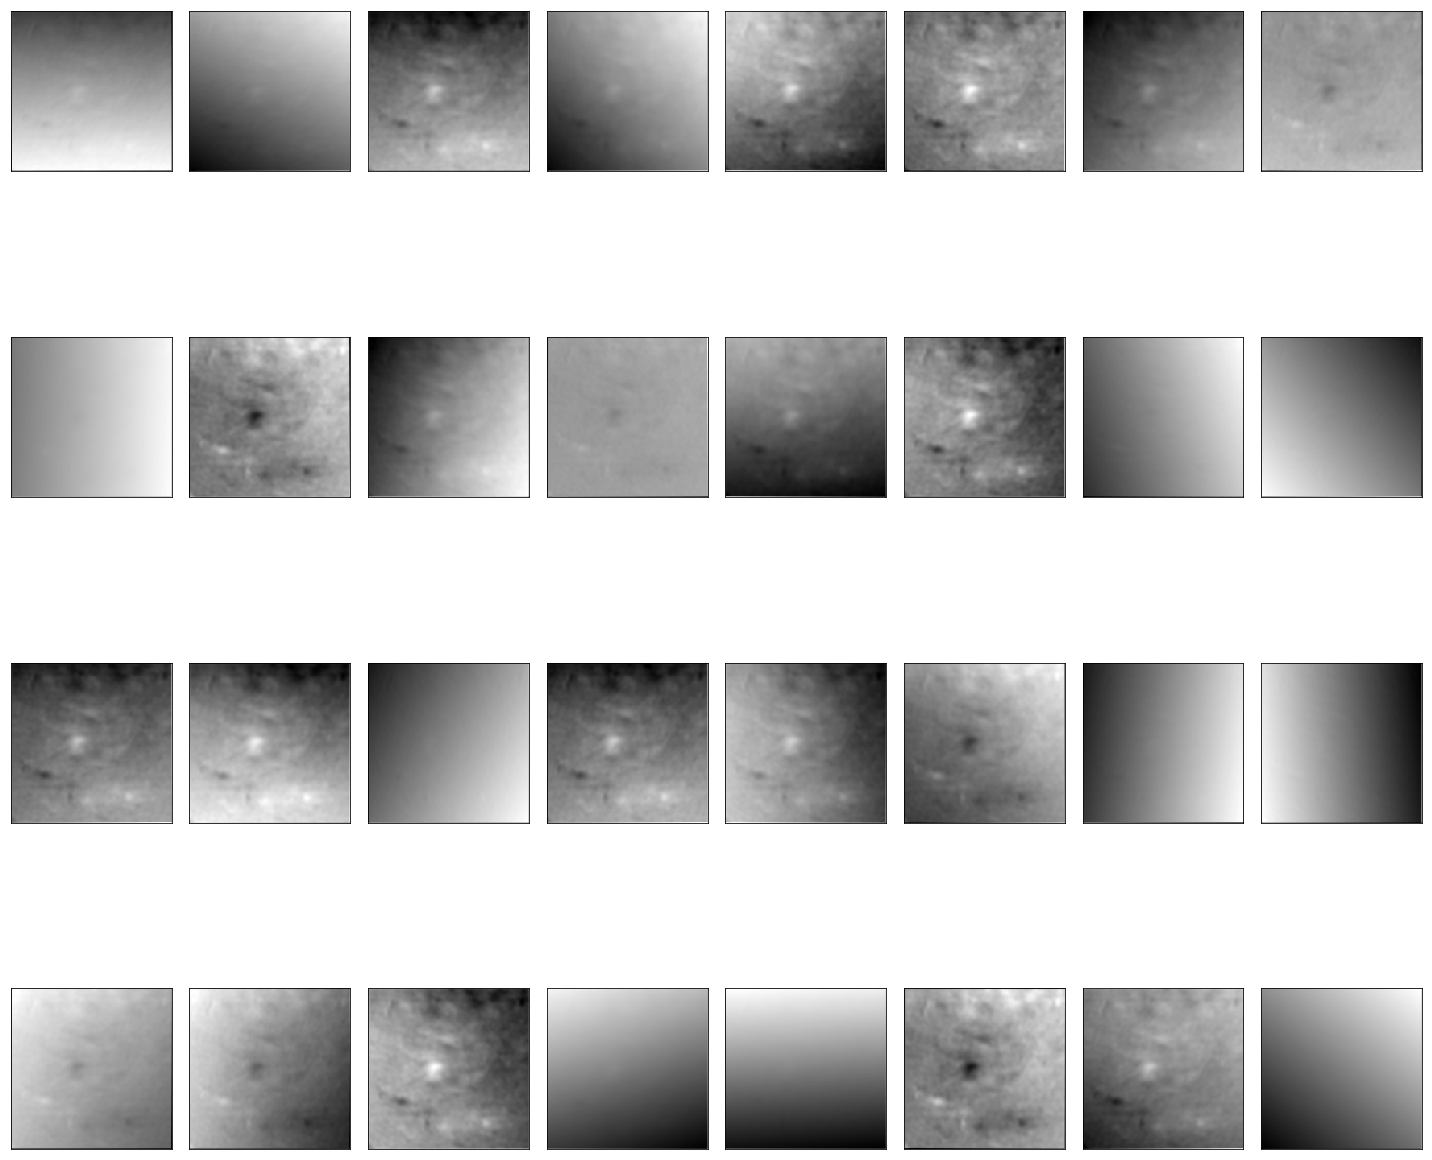

In [21]:
test_map02 = feature_maps(model, '{}'.format(layer_name), test_img)
plot_feature_maps(test_map02, 4, 8, figsize = (20,20))

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
coord_conv (CoordConv)       (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization_v2 (Batc (None, 200, 200, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 200, 200, 32)      0         
_________________________________________________________________
coord_conv_1 (CoordConv)     (None, 200, 200, 64)      19648     
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 200, 200, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 200, 200, 64)      0     